# 1. Імпорт бібліотек, встановлення сіду, налаштування pytorch на роботу на cuda

In [31]:
import torch
import numpy as np
import random
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader, random_split, TensorDataset, ConcatDataset
import matplotlib.pyplot as plt
from torchvision.models import googlenet, GoogLeNet_Weights, resnet18, ResNet18_Weights
from torch import nn
from torch.optim import Adam

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")


Using device: cuda
CUDA Device: NVIDIA GeForce RTX 2060


# 2. Завантаження FasionMNIST

In [32]:
transform = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,)),
])

data_path = './data/lab3'
dataset = FashionMNIST(root=data_path, train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root=data_path, train=False, download=True, transform=transform)

0.2%

100.0%


Extracting ./data/lab3/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/lab3/FashionMNIST/raw



100.0%


Extracting ./data/lab3/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/lab3/FashionMNIST/raw



100.0%


Extracting ./data/lab3/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/lab3/FashionMNIST/raw



100.0%

Extracting ./data/lab3/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/lab3/FashionMNIST/raw



# 3. Відображення декількох зображень з набору даних

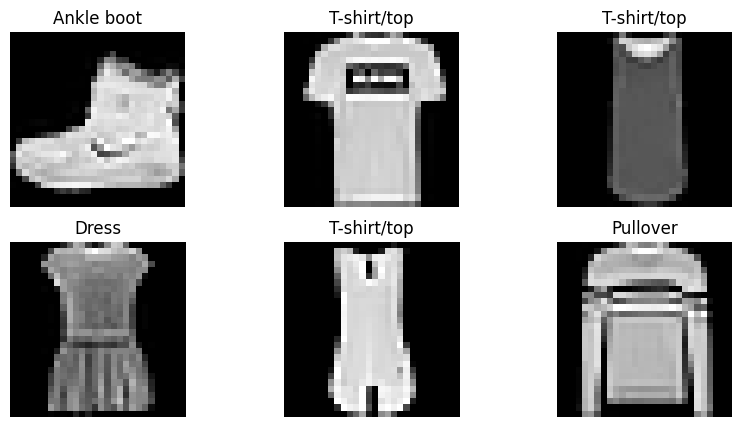

In [33]:
classes = dataset.classes

n_images = 6
rows, cols = 2, 3
figure = plt.figure(figsize=(10, 5))

for i in range(n_images):
    img, label = dataset[i]
    img = img.permute(1, 2, 0).numpy()
    ax = figure.add_subplot(rows, cols, i + 1)
    ax.imshow((img * 0.5) + 0.5, cmap='gray')
    ax.set_title(f"{classes[label]}")
    ax.axis('off')

plt.show()

# 4. Розділення даних на вибірки

In [34]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator())
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")

labeled_size = int(0.3 * len(train_dataset))
unlabeled_size = len(train_dataset) - labeled_size
labeled_dataset, unlabeled_dataset = random_split(train_dataset, [labeled_size, unlabeled_size])

print(f"Labeled dataset size: {len(labeled_dataset)}")
print(f"Unlabeled dataset size: {len(unlabeled_dataset)}")

Train size: 48000, Validation size: 12000
Labeled dataset size: 14400
Unlabeled dataset size: 33600


In [35]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Ініціалізація моделей

In [36]:
def initialize_googlenet(num_classes=10, in_channels=1, aux_logits=True):
    model = googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1, aux_logits=aux_logits)
    model.conv1 = nn.Conv2d(
        in_channels=in_channels,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
        bias=False
    )
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    if aux_logits:
        model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
        model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)
    model.transform_input = False
    return model

def initialize_resnet18(num_classes=10, in_channels=1):
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(
        in_channels=in_channels,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
        bias=False
    )
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model1 = initialize_googlenet(num_classes=10, aux_logits=True).to(device)
model2 = initialize_resnet18(num_classes=10).to(device)

/mnt/c/Users/HeyHo/Documents/GitHub/googlenet-fashionmnist/venv/lib/python3.12/site-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


# 6. Функції для навчання та тестування моделей

In [37]:
def calculate_loss(outputs, targets, criterion):
    if not isinstance(outputs, tuple):
        return criterion(outputs, targets)
    elif len(outputs) == 3:
        main_out, aux1_out, aux2_out = outputs
        main_loss = criterion(main_out, targets)
        aux1_loss = criterion(aux1_out, targets)
        aux2_loss = criterion(aux2_out, targets)
        return main_loss + 0.3 * (aux1_loss + aux2_loss)
    else:
        raise ValueError("Непередбачений формат виходу моделі.")

def train_model(model, train_loader, val_loader, num_epochs, optimizer, criterion, model_name, save_path=None):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = calculate_loss(outputs, labels, criterion)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc  = 100.0 * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = calculate_loss(outputs, labels, criterion)
                val_loss += loss.item()

                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc  = 100.0 * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] ({model_name}): '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
    
    if save_path is not None:
        torch.save(model.state_dict(), save_path)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Acc")
    plt.plot(range(1, num_epochs+1), val_accuracies, label="Val Acc")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def test_model(model, test_loader, criterion, model_name="Model"):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                main_out = outputs[0]
            else:
                main_out = outputs

            loss = criterion(main_out, labels)
            test_loss += loss.item()

            _, predicted = torch.max(main_out, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100.0 * correct / total
    test_loss = test_loss / len(test_loader)
    print(f"\n{model_name} Test Results:")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")
    return test_accuracy, test_loss

# 7. Кероване навчання моделей GoogLeNet та ResNet18

/mnt/c/Users/HeyHo/Documents/GitHub/googlenet-fashionmnist/venv/lib/python3.12/site-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch [1/15] (Default GoogLeNet): Train Loss: 0.8974, Train Acc: 80.75% | Val Loss: 0.4365, Val Acc: 84.80%
Epoch [2/15] (Default GoogLeNet): Train Loss: 0.6035, Train Acc: 86.97% | Val Loss: 0.3418, Val Acc: 87.60%
Epoch [3/15] (Default GoogLeNet): Train Loss: 0.5319, Train Acc: 88.36% | Val Loss: 0.3293, Val Acc: 87.88%
Epoch [4/15] (Default GoogLeNet): Train Loss: 0.5059, Train Acc: 89.08% | Val Loss: 0.2979, Val Acc: 89.16%
Epoch [5/15] (Default GoogLeNet): Train Loss: 0.4680, Train Acc: 90.09% | Val Loss: 0.2917, Val Acc: 89.53%
Epoch [6/15] (Default GoogLeNet): Train Loss: 0.4081, Train Acc: 91.23% | Val Loss: 0.2967, Val Acc: 89.31%
Epoch [7/15] (Default GoogLeNet): Train Loss: 0.3719, Train Acc: 91.84% | Val Loss: 0.3142, Val Acc: 88.73%
Epoch [8/15] (Default GoogLeNet): Train Loss: 0.3788, Train Acc: 91.89% | Val Loss: 0.2621, Val Acc: 90.78%
Epoch [9/15] (Default GoogLeNet): Train Loss: 0.3544, Train Acc: 92.18% | Val Loss: 0.2677, Val Acc: 90.61%
Epoch [10/15] (Default GoogL

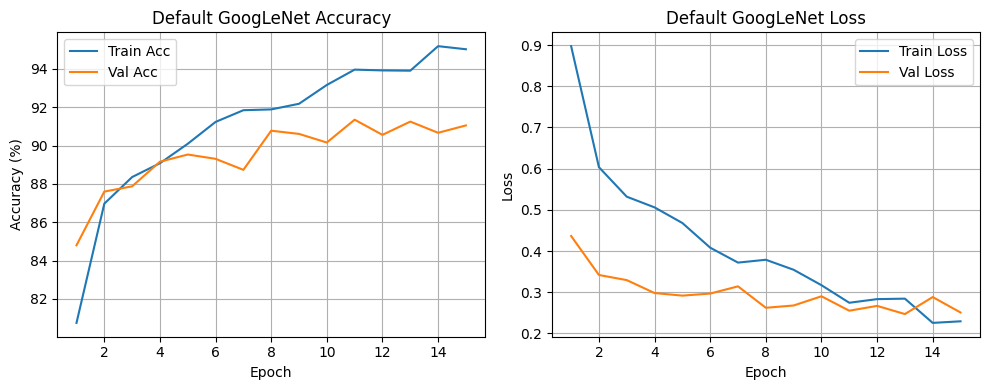

Epoch [1/15] (Default Resnet18): Train Loss: 0.5203, Train Acc: 81.38% | Val Loss: 0.4189, Val Acc: 84.03%
Epoch [2/15] (Default Resnet18): Train Loss: 0.3555, Train Acc: 87.12% | Val Loss: 0.3182, Val Acc: 87.85%
Epoch [3/15] (Default Resnet18): Train Loss: 0.3054, Train Acc: 88.82% | Val Loss: 0.3122, Val Acc: 88.04%
Epoch [4/15] (Default Resnet18): Train Loss: 0.2677, Train Acc: 90.11% | Val Loss: 0.2721, Val Acc: 89.42%
Epoch [5/15] (Default Resnet18): Train Loss: 0.2621, Train Acc: 90.60% | Val Loss: 0.3147, Val Acc: 89.08%
Epoch [6/15] (Default Resnet18): Train Loss: 0.2353, Train Acc: 91.46% | Val Loss: 0.2594, Val Acc: 90.33%
Epoch [7/15] (Default Resnet18): Train Loss: 0.2085, Train Acc: 92.46% | Val Loss: 0.2583, Val Acc: 90.30%
Epoch [8/15] (Default Resnet18): Train Loss: 0.1866, Train Acc: 92.97% | Val Loss: 0.2517, Val Acc: 91.02%
Epoch [9/15] (Default Resnet18): Train Loss: 0.1842, Train Acc: 93.26% | Val Loss: 0.2740, Val Acc: 90.05%
Epoch [10/15] (Default Resnet18): Tra

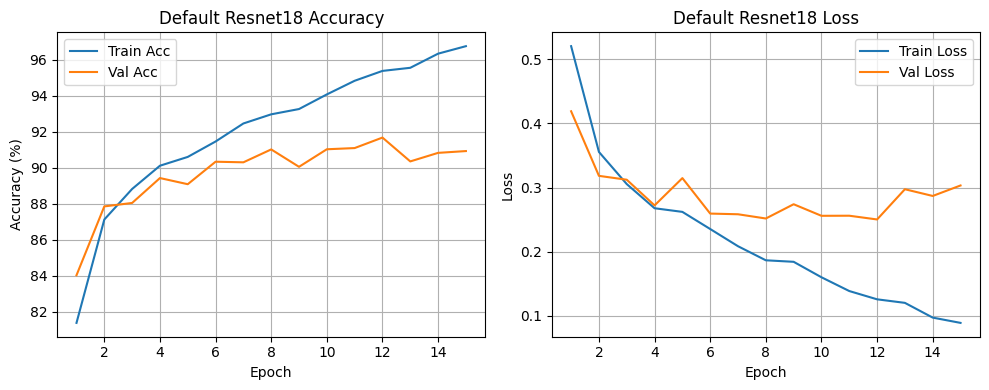

In [39]:
criterion=nn.CrossEntropyLoss()

googlenet_supervised = initialize_googlenet().to(device)
resnet18_supervised = initialize_resnet18().to(device)

train_model(googlenet_supervised, train_loader=train_loader, val_loader=val_loader, num_epochs=15, optimizer=Adam(googlenet_supervised.parameters(), lr=0.001), criterion=criterion, model_name="Default GoogLeNet", save_path="../models/lab3/googlenet_supervised.pth")
train_model(resnet18_supervised, train_loader=train_loader, val_loader=val_loader, num_epochs=15, optimizer=Adam(resnet18_supervised.parameters(), lr=0.001), criterion=criterion, model_name="Default Resnet18", save_path="../models/lab3/resnet18_supervised.pth")

# 8. Тестування моделей

In [41]:
test_accuracy_model, test_loss_model = test_model(model=googlenet_supervised, test_loader=test_loader, criterion=criterion, model_name="Default GoogleNet")
test_accuracy_model, test_loss_model = test_model(model=resnet18_supervised, test_loader=test_loader, criterion=criterion, model_name="Default Resnet18")


Default GoogleNet Test Results:
Test Loss: 0.2672, Test Accuracy: 91.15%


Default Resnet18 Test Results:
Test Loss: 0.3258, Test Accuracy: 90.64%



# 9. Напівкероване навчання моделей (Democratic co-training)

## 9.1 Навчання моделей на маркованих даних

Epoch [1/15] (GoogLeNet Labeled): Train Loss: 1.2573, Train Acc: 72.59% | Val Loss: 0.5131, Val Acc: 81.79%
Epoch [2/15] (GoogLeNet Labeled): Train Loss: 0.7921, Train Acc: 82.65% | Val Loss: 0.5102, Val Acc: 81.99%
Epoch [3/15] (GoogLeNet Labeled): Train Loss: 0.6793, Train Acc: 85.53% | Val Loss: 0.4356, Val Acc: 84.79%
Epoch [4/15] (GoogLeNet Labeled): Train Loss: 0.5967, Train Acc: 87.23% | Val Loss: 0.3983, Val Acc: 85.67%
Epoch [5/15] (GoogLeNet Labeled): Train Loss: 0.5611, Train Acc: 87.97% | Val Loss: 0.3747, Val Acc: 87.03%
Epoch [6/15] (GoogLeNet Labeled): Train Loss: 0.4605, Train Acc: 89.99% | Val Loss: 0.3534, Val Acc: 87.66%
Epoch [7/15] (GoogLeNet Labeled): Train Loss: 0.4499, Train Acc: 90.06% | Val Loss: 0.3676, Val Acc: 87.20%
Epoch [8/15] (GoogLeNet Labeled): Train Loss: 0.5641, Train Acc: 88.60% | Val Loss: 0.4222, Val Acc: 85.62%
Epoch [9/15] (GoogLeNet Labeled): Train Loss: 0.4384, Train Acc: 90.72% | Val Loss: 0.3955, Val Acc: 86.52%
Epoch [10/15] (GoogLeNet Lab

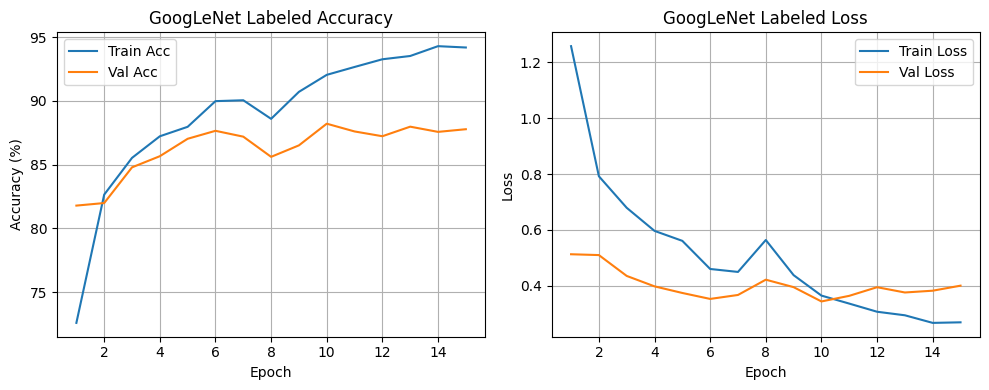

Epoch [1/15] (ResNet18 Labeled): Train Loss: 0.6985, Train Acc: 75.44% | Val Loss: 0.5399, Val Acc: 80.86%
Epoch [2/15] (ResNet18 Labeled): Train Loss: 0.4694, Train Acc: 83.19% | Val Loss: 0.4665, Val Acc: 82.62%
Epoch [3/15] (ResNet18 Labeled): Train Loss: 0.3989, Train Acc: 85.54% | Val Loss: 0.5036, Val Acc: 82.32%
Epoch [4/15] (ResNet18 Labeled): Train Loss: 0.3627, Train Acc: 87.00% | Val Loss: 0.3860, Val Acc: 85.82%
Epoch [5/15] (ResNet18 Labeled): Train Loss: 0.3170, Train Acc: 88.49% | Val Loss: 0.3915, Val Acc: 86.26%
Epoch [6/15] (ResNet18 Labeled): Train Loss: 0.2850, Train Acc: 89.53% | Val Loss: 0.4514, Val Acc: 83.75%
Epoch [7/15] (ResNet18 Labeled): Train Loss: 0.2743, Train Acc: 90.11% | Val Loss: 0.3472, Val Acc: 87.67%
Epoch [8/15] (ResNet18 Labeled): Train Loss: 0.2476, Train Acc: 90.67% | Val Loss: 0.3489, Val Acc: 87.40%
Epoch [9/15] (ResNet18 Labeled): Train Loss: 0.2249, Train Acc: 91.67% | Val Loss: 0.3615, Val Acc: 87.72%
Epoch [10/15] (ResNet18 Labeled): Tra

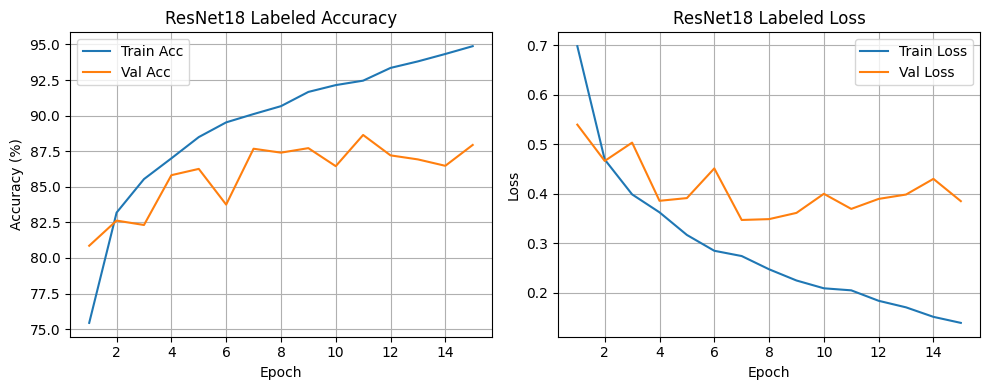

In [42]:
optimizer1 = Adam(model1.parameters(), lr=0.001)
optimizer2 = Adam(model2.parameters(), lr=0.001)

train_model(model=model1, train_loader=labeled_loader, val_loader=val_loader, num_epochs=15,
            optimizer=optimizer1, criterion=criterion, 
            model_name="GoogLeNet Labeled",
            save_path="../models/lab3/googlenet_labeled.pth")

train_model(model2, train_loader=labeled_loader, val_loader=val_loader, num_epochs=15,
            optimizer=optimizer2, criterion=criterion, 
            model_name="ResNet18 Labeled",
            save_path="../models/lab3/resnet18_labeled.pth")

## 9.2 Генерація псевдо-міток

In [43]:
model1.eval()
model2.eval()

agreed_images = []
agreed_labels = []

with torch.no_grad():
    unl_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=False)
    for images, _ in unl_loader:
        images = images.to(device)
        outputs1 = model1(images)
        outputs2 = model2(images)

        if isinstance(outputs1, tuple):
            outputs1 = outputs1[0]
        if isinstance(outputs2, tuple):
            outputs2 = outputs2[0]

        _, predicted1 = torch.max(outputs1, 1)
        _, predicted2 = torch.max(outputs2, 1)

        mask = (predicted1 == predicted2)
        if mask.any():
            agreed_idx = mask.nonzero(as_tuple=True)[0]
            selected_imgs = images[agreed_idx].cpu()
            selected_labels = predicted1[agreed_idx].cpu()

            agreed_images.append(selected_imgs)
            agreed_labels.append(selected_labels)

if len(agreed_images) > 0:
    agreed_images = torch.cat(agreed_images, dim=0)
    agreed_labels = torch.cat(agreed_labels, dim=0)
else:
    agreed_images = torch.tensor([], dtype=torch.float32)
    agreed_labels = torch.tensor([], dtype=torch.long)

print(f"Generated {len(agreed_images)} pseudo-labels")


Generated 30034 pseudo-labels


# 9.3 Створення комбінованого датасету

In [44]:
pseudo_dataset = TensorDataset(agreed_images, agreed_labels)

labeled_images = []
labeled_labels = []
for img, lab in labeled_dataset:
    labeled_images.append(img.unsqueeze(0))

labeled_images = torch.cat(labeled_images, dim=0)
labeled_labels = torch.tensor([lab for _, lab in labeled_dataset], dtype=torch.long)

labeled_tensor_dataset = TensorDataset(labeled_images, labeled_labels)

combined_dataset = ConcatDataset([labeled_tensor_dataset, pseudo_dataset])

## 9.4 Навчання на маркованих та псевдо-маркованих даних

Epoch [1/15] (GoogLeNet Democratic): Train Loss: 0.2941, Train Acc: 94.73% | Val Loss: 0.3905, Val Acc: 86.86%
Epoch [2/15] (GoogLeNet Democratic): Train Loss: 0.2848, Train Acc: 94.97% | Val Loss: 0.3766, Val Acc: 89.01%
Epoch [3/15] (GoogLeNet Democratic): Train Loss: 0.2490, Train Acc: 95.62% | Val Loss: 0.3677, Val Acc: 88.68%
Epoch [4/15] (GoogLeNet Democratic): Train Loss: 0.1722, Train Acc: 96.55% | Val Loss: 0.4174, Val Acc: 87.73%
Epoch [5/15] (GoogLeNet Democratic): Train Loss: 0.1859, Train Acc: 96.64% | Val Loss: 0.3963, Val Acc: 87.97%
Epoch [6/15] (GoogLeNet Democratic): Train Loss: 0.1520, Train Acc: 97.01% | Val Loss: 0.3788, Val Acc: 88.47%
Epoch [7/15] (GoogLeNet Democratic): Train Loss: 0.1413, Train Acc: 97.17% | Val Loss: 0.4237, Val Acc: 88.58%
Epoch [8/15] (GoogLeNet Democratic): Train Loss: 0.1354, Train Acc: 97.34% | Val Loss: 0.4145, Val Acc: 88.62%
Epoch [9/15] (GoogLeNet Democratic): Train Loss: 0.1453, Train Acc: 97.34% | Val Loss: 0.4212, Val Acc: 88.19%
E

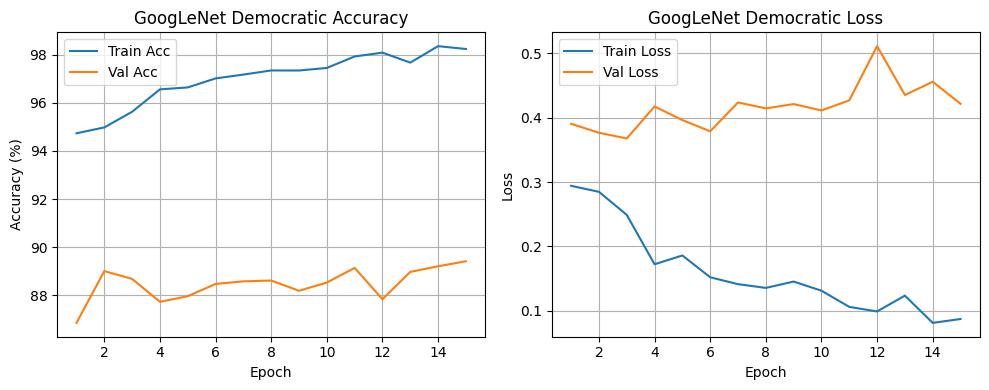

Epoch [1/15] (ResNet18 Democratic): Train Loss: 0.1402, Train Acc: 95.18% | Val Loss: 0.4197, Val Acc: 88.09%
Epoch [2/15] (ResNet18 Democratic): Train Loss: 0.1117, Train Acc: 95.99% | Val Loss: 0.3661, Val Acc: 88.96%
Epoch [3/15] (ResNet18 Democratic): Train Loss: 0.1012, Train Acc: 96.60% | Val Loss: 0.4124, Val Acc: 88.47%
Epoch [4/15] (ResNet18 Democratic): Train Loss: 0.0956, Train Acc: 96.75% | Val Loss: 0.4307, Val Acc: 88.51%
Epoch [5/15] (ResNet18 Democratic): Train Loss: 0.0786, Train Acc: 97.27% | Val Loss: 0.4046, Val Acc: 88.39%
Epoch [6/15] (ResNet18 Democratic): Train Loss: 0.0675, Train Acc: 97.69% | Val Loss: 0.4564, Val Acc: 88.35%
Epoch [7/15] (ResNet18 Democratic): Train Loss: 0.0624, Train Acc: 97.82% | Val Loss: 0.4346, Val Acc: 88.43%
Epoch [8/15] (ResNet18 Democratic): Train Loss: 0.0548, Train Acc: 98.13% | Val Loss: 0.4395, Val Acc: 88.95%
Epoch [9/15] (ResNet18 Democratic): Train Loss: 0.0576, Train Acc: 98.02% | Val Loss: 0.5021, Val Acc: 87.92%
Epoch [10/

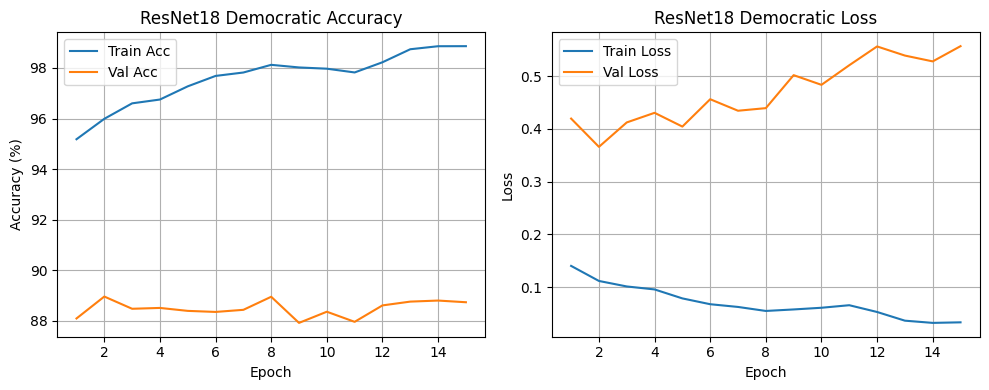

In [45]:
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

model1 = model1.to(device)
model2 = model2.to(device)

optimizer1 = Adam(model1.parameters(), lr=0.001)
optimizer2 = Adam(model2.parameters(), lr=0.001)

train_model(model=model1, train_loader=combined_loader, val_loader=val_loader, num_epochs=15,
            optimizer=optimizer1, criterion=criterion,
            model_name="GoogLeNet Democratic",
            save_path="./googlenet_democratic.pth")

train_model(model=model2, train_loader=combined_loader, val_loader=val_loader, num_epochs=15,
            optimizer=optimizer2, criterion=criterion,
            model_name="ResNet18 Democratic",
            save_path="./resnet18_democratic.pth")


## 9.5 Тестування отриманих моделей

In [46]:
test_model(model=model1, test_loader=test_loader, criterion=criterion, model_name="GoogLeNet Democratic")
test_model(model=model2, test_loader=test_loader, criterion=criterion, model_name="ResNet18 Democratic")


GoogLeNet Democratic Test Results:
Test Loss: 0.4631, Test Accuracy: 89.18%


ResNet18 Democratic Test Results:
Test Loss: 0.5778, Test Accuracy: 88.37%



(88.37, 0.5778315151288251)